<a href="https://colab.research.google.com/github/Zain506/Similarity/blob/main/notebooks/medclipsam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MedCLIP-SAM

Importing MedPIX dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("adishourya/MEDPIX-ClinQA")
print(ds)

Import Microsoft's PubMedBERT text encoder

In [2]:
%pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
import open_clip

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

In [4]:
import json
example = ds["train"][0].copy()
del example["image_id"] # Remove PIL object due to problematic rendering
print(json.dumps(example, indent=4))

{
    "mode": "alignment",
    "case_id": "MPX1686",
    "question": " How does the interhemispheric fissure appear in this image?",
    "answer": " The anterior interhemispheric fissure is partially formed, but the rest of the fissure is not visible."
}


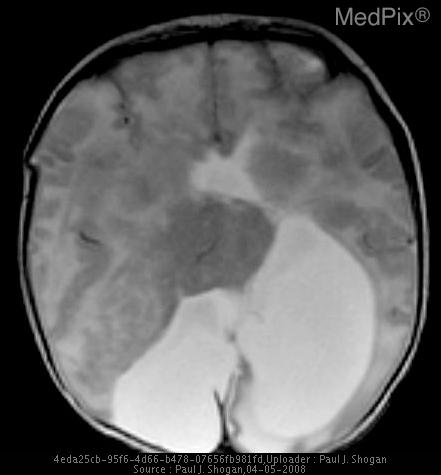

In [5]:
ds["train"][0]["image_id"]

In [ ]:
import torch
from PIL import Image
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(ds["train"][1]["image_id"]).unsqueeze(0)
text = tokenizer(["anterior interhemispheric fissure", "subcranial hematoma"])
print(type(text))

with torch.no_grad(), torch.autocast("cuda"):
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

In [7]:
print(text_features.shape)

torch.Size([2, 512])
